# Neccesary modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Get the data

### RF data 

In [3]:
background_rf = np.load("data/backgroundRF_resampled.npy")
drone_rf = np.load("data/droneRF_resampled.npy")

## Image data

In [4]:
background_imgs = np.load("data/images_background.npy", allow_pickle=True)
drone_imgs = np.load("data/images_drone.npy", allow_pickle=True)

In [5]:
drone_imgs /= 255
background_imgs /= 255

In [6]:
random.shuffle(drone_imgs)
random.shuffle(background_imgs)

# Train/ test split and data formatting

In [7]:
import cv2
images_data = np.append(background_imgs[0:len(background_rf)], 
                   drone_imgs[0:len(drone_rf)], axis=0)
images_resized = []
for i, img in enumerate(images_data):
    images_resized.append(cv2.resize(img, (256, 256), 
                                interpolation = cv2.INTER_AREA))
    images_resized[i] = np.expand_dims(images_resized[i], axis=3)

/home/NewUsersDir/mohammed/nkalathi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [8]:
images_resized = np.array(images_resized)

In [9]:
print(images_resized.shape)

(80, 256, 256, 1)


In [10]:
Y = np.array([0 for i in enumerate(background_rf)] + [1 for i in enumerate(drone_rf)])
X = np.append(background_rf,drone_rf,axis=0)
Y = Y.reshape(-1,1)

In [11]:
def format_data(rf_data,images):
    low = []
    high = []
    images = images
    for i, rf in enumerate(rf_data):
        low.append(rf[0].astype(np.float16).flatten())
        high.append(rf[1].astype(np.float16).flatten())
    low = np.array(low)
    high = np.array(high)
    images = np.array(images)
    return [low, high, images]
X = format_data(X, images_resized)


In [12]:
def join_data(x_data):
    data = []
    for i in range(len(x_data[0])):
        data.append((x_data[0][i], x_data[1][i], x_data[2][i]))
    return data
def unjoin_data(x_data):
    low = []
    high = []
    imags = []
    for x in x_data:
        low.append(x[0])
        high.append(x[1])
        imags.append(x[2])
    low = np.array(low)
    high = np.array(high)
    imags = np.array(imags)
    return [low, high, imags] 
X = join_data(X)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [14]:
x_test = unjoin_data(x_test)
x_train = unjoin_data(x_train)

In [15]:
x_train[0].shape

(56, 4882)

# Model

In [16]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, concatenate
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

img_shape = (256,256,1)
# define three sets of inputs
low_rf  = Input(shape=(x_train[0].shape[1],))
high_rf = Input(shape=(x_train[1].shape[1],))

# the first branch operates on the first input
x1 = Dense(100 , activation="relu")(low_rf)
x1 = Dense(50, activation="relu")(x1)
x1 = Model(inputs=low_rf, outputs=x1)

# the second branch operates on the second input
x2 = Dense(100 , activation="relu")(high_rf)
x2 = Dense(50, activation="relu")(x2)
x2 = Model(inputs=high_rf, outputs=x2)

# third branch for images 
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape))
cnn.add(BatchNormalization())

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Dense(128, activation='relu'))

# combine the output of the two branches
combined = concatenate([x1.output, x2.output, cnn.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(10, activation="relu")(combined)
z = Dense(1, activation="sigmoid")(z)

model = Model(inputs=[x1.input, x2.input, cnn.input], outputs=z)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 254, 254, 32) 320         conv2d_input[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 254, 254, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 252, 252, 32) 9248        batch_normalization[0][0]        
____________________________________________________________________________________________

In [17]:
model.compile(optimizer ='adam' , loss = "binary_crossentropy", metrics=["accuracy"])

## Generate model picture

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

# Train Model

In [18]:
batch_size =1
epochs = 3
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 56 samples, validate on 24 samples
Epoch 1/3
56/56 [==============================] - 8s 145ms/sample - loss: 0.6085 - accuracy: 0.6607 - val_loss: 0.4606 - val_accuracy: 0.8333
Epoch 2/3
56/56 [==============================] - 4s 80ms/sample - loss: 0.1540 - accuracy: 0.9821 - val_loss: 0.4694 - val_accuracy: 0.8333
Epoch 3/3
56/56 [==============================] - 4s 80ms/sample - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.5120 - val_accuracy: 0.7917


# Evaluate Model

In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5120420455932617
Test accuracy: 0.7916667


In [20]:
THRESHOLD = 0.5
predictions = model.predict(x_test)

# predictions = (predictions > THRESHOLD)
print(predictions)

[[0.24265236]
 [0.20384699]
 [0.01700017]
 [0.28676224]
 [0.00672624]
 [0.25819   ]
 [0.25713205]
 [0.23931003]
 [0.01865175]
 [0.0350244 ]
 [0.32323837]
 [0.0475032 ]
 [0.6486509 ]
 [0.22804645]
 [0.9581479 ]
 [0.02113104]
 [0.98134875]
 [0.25115043]
 [0.528554  ]
 [0.07326195]
 [0.33905202]
 [0.9906651 ]
 [0.17063457]
 [0.42885685]]


## Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, (predictions> THRESHOLD))
print(cm)

[[14  0]
 [ 5  5]]


# Precision recall curve

[0.02113104 0.0350244  0.0475032  0.07326195 0.17063457 0.20384699
 0.22804645 0.23931003 0.24265236 0.25115043 0.25713205 0.25819
 0.28676224 0.32323837 0.33905202 0.42885685 0.528554   0.6486509
 0.9581479  0.98134875 0.9906651 ]


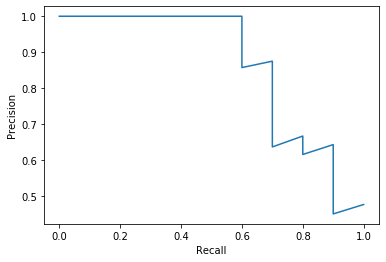

In [22]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
print(thresholds)

In [23]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.87
